# Использование натуральных и синтетических ингредиентов в косметике

Представляем вашему вниманию проект, в котором хотим изучить, на самом ли деле косметические бренды, заявляющие, что ориентируются
на натуральные ингредиенты, отказываются от синтетических компонентов и как это, с точки зрения потребителей, отражается
на качестве продуктов.

Гипотезы:
1. Компании не всегда открыто представляют состав своих продуктов.
2. Если компания позиционирует, что ориентируется на натуральные составы, вероятно, она маскирует часть синтетических ингредиентов или даже опасных синтетических.
3. Чем больше натуральных ингредиентов в составе продукта, тем выше цена, тем выше оценка, тем больше отзывов.
4. Приверженность натуральным составам варьируется в разных категориях товаров.
5. Больше всего синтетических ингредиентов в категории "Парфюмерия"

Задачи:
1. Собрать данные с экспертного портала по дерматологии.
2. Выяснить, какие компоненты в косметике относятся к опасным синтетическим.
3. Проанализировать сайты интернет-магазинов брендов Yves Rocher и Body Shop.
4. Выявить, содержатся ли в составе продуктов перечисленных брендов вещества, которые дерматологи относят к опасным синтетическим.
4. Проанализировать зависимость доли натуральных ингредиентов от цены, оценки и количества отзывов, а также рассмотреть, как это проявляется в разных категориях товаров.
5. Визуализировать полученные данные.
6. Опираясь на данные полученных графиков, выявить наличие или отсутствие корреляции а) между позицией компании и наличием в составе её косметики синтетических ингредиентов/опасных синтетических ингредиентов, б) между "выполнением/невыполнением обещаний", в) между долей натуральных ингредиентов, ценой, оценкой и количеством отзывов, г) между долей натуральных ингредиентов и категорией товара.

Ограничения, связанные с тем, что сайты устроены по-разному:
1. The Body Shop не разделяет ингредиенты в составах на натуральные и ненатуральные, поэтому мы не можем вычислить процент натуральных для каждой категории.
2. Оба сайта не прописывают долю определенных ингредиентов в составе продукта. Поэтому долю натуральных мы определяем по количеству названий. При этом это достаточно репрезентативная информация, так как пользователю других данных тоже не представлено.
3. С сайта The Body Shop не вычленяется количество отзывов, поэтому корреляции натуральности и количества отзывов мы проанализировали и визуализировали только для Yves Rocher.

## Импорт необходимых библиотек для проекта

In [ ]:
''' Импортируем библиотеки для парсинга '''
!pip install pyyaml ua-parser user-agents fake-useragent
!pip install selenium
!pip install webdriver-manager


import time
import requests 
import logging
from bs4 import BeautifulSoup as bs 
from fake_useragent import UserAgent
from tqdm.notebook import trange 
import sys
import re
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import random
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


## Сбор данных с экспертного портала по дерматологии

In [41]:
'''Прежде чем чем искать синтетические компоненты в продуктах косметических брендов, составим список таких компонентов. Для
этого соберём информацию с тематического сайта.'''

UserAgent().chrome
 
url = 'https://www.handmadenaturals.co.uk/synthetic_cosmetic_ingredients_to_avoid.php'
response = requests.get(url, headers={'User-Agent': UserAgent().chrome})
response

<Response [200]>

In [45]:
'''На странице два блока синтетических ингредиентов. В первом у интересующих нас объектов тип <span>, во втором <b>.
Сначала пытаемся получить <span>, если вылетает ошибка, пробуем получить <b>. Если и в этом случае ошибка, то пропускаем 
элемент (значит, что это не название ингредиента, а что-то другое: например, ссылка, которая нас не интересует).'''

bad_cosmetics = []
tree = bs(response.content, 'html.parser')
ingredients = tree.find('div', {'class': 'product-single-info clearfix' }).find_all('p')[1:]
for ingredient in ingredients:
    try:
        bad_cosmetics.append(ingredient.span.text.strip())
    except:
        try:
            bad_cosmetics.append(ingredient.b.text.strip())
        except:
            pass   

In [46]:
'''Получаем список, который явно нужно почистить от лишних пробелов и цифр.'''

bad_cosmetics

['1. Methyl, Propyl, Butyl and \n                          Ethyl Paraben',
 '2. Diethanolamine (DEA), Triethanolamine \n                          (TEA)',
 '3. Diazolidinyl Urea, Imidazolidinyl \n                          Urea',
 '4. Sodium Lauryl/Laureth Sulfate \n                          (SLS/SLES)',
 '5. Petrolatum',
 '6. Propylene Glycol',
 '7. PVP/VA Copolymer',
 '8. Stearalkonium Chloride',
 '9. Synthetic Colors',
 '10. Synthetic Fragrances',
 'Alcohol Denat',
 'Alcohol, Isopropyl',
 'Fluoride',
 'Lead',
 'Mineral Oil',
 'Petroleum Distillates',
 'Phenylphenol',
 'Phthalates',
 'Sodium Chloride',
 'Sodium Lauryl Sulfate (SLS) & \n                          Sodium Laureth Sulfate (SLES)',
 'Talc',
 'Triclosan',
 'Zinc Oxide']

In [47]:
'''Убираем пробельные символы. Сначала устраняем переходы на новую строку с помощью метода строк replace, затем, используя 
регулярные выражения, избавляемся от многочисленных пробелов.'''

for i in range(len(bad_cosmetics)):
    bad_cosmetics[i] = bad_cosmetics[i].replace('\n', '')
    bad_cosmetics[i] = re.sub(' +', ' ', bad_cosmetics[i])

In [48]:
'''Убираем нумерацию ингредиентов из первого блока, то есть чистим от комбинации "число. " первые 10 элементов списка.'''

for i in range(11):
    bad_cosmetics[i] = bad_cosmetics[i].lstrip(f'{i+1}. ')

In [49]:
'''Некоторые элементы списка включают в себя несколько типов одного класса. Например, в одном пунктеперечислено сразу 
четыре вида парабенов. Вручную (поскольку это частный случай) разделим этот пункт на несколько и удалим из списка исходную
позицию.'''

bad_cosmetics.remove('Methyl, Propyl, Butyl and Ethyl Paraben')
bad_cosmetics.append('Methyl Paraben')
bad_cosmetics.append('Propyl Paraben')
bad_cosmetics.append('Butyl Paraben')
bad_cosmetics.append('Ethyl Paraben')

In [50]:
'''Аналогично поступим с пунктом "PVP/VA Copolymer"'", где разновидности вещества разделены слэшем.'''

bad_cosmetics.remove('PVP/VA Copolymer')
bad_cosmetics.append('PVP Copolymer')
bad_cosmetics.append('VA Copolymer')

In [51]:
'''В списке синтетических компонентов, который мы составили, на первом месте обычно стоит определение, тип какого-то вещества,
а потом уже название или класс этого вещества. В случае с "Alcohol, Isopropyl" всё наоборот. Приведём этот элемент 
к "стандартному" в рамках нашего списка виду.'''

bad_cosmetics.remove('Alcohol, Isopropyl')
bad_cosmetics.append('Isopropyl Alcohol')

In [52]:
'''Заметим, что преобразовывать пункт "Sodium Lauryl/Laureth Sulfate (SLS/SLES)" нет смысла: в списке (видимо, за счёт того,
что мы сформировали его из двух блоков) есть более удобный для преобразования элемент аналогичного содержания: 
"Sodium Lauryl Sulfate (SLS) & Sodium Laureth Sulfate (SLES)". Поэтому просто удалим пункт со слэшем.'''

bad_cosmetics.remove('Sodium Lauryl/Laureth Sulfate (SLS/SLES)')

In [53]:
'''В списке остались пункты, где запятой или символом "&" соединены два ингредиента. Превратим такие строки в списки и добавим
каждый из элементов по отдельности в новый список - cosmetics_list. Для удобства отсортируем его и выведем так, чтобы каждый
элемент оказался на новой строчке.'''

cosmetics_list = []
for name in bad_cosmetics:
    t = re.split(', | and | & ', name)
    for i in range(len(t)):
        cosmetics_list.append(t[i])
print('\n'.join(sorted(cosmetics_list)))

Alcohol Denat
Butyl Paraben
Diazolidinyl Urea
Diethanolamine (DEA)
Ethyl Paraben
Fluoride
Imidazolidinyl Urea
Isopropyl Alcohol
Lead
Methyl Paraben
Mineral Oil
PVP Copolymer
Petrolatum
Petroleum Distillates
Phenylphenol
Phthalates
Propyl Paraben
Propylene Glycol
Sodium Chloride
Sodium Laureth Sulfate (SLES)
Sodium Lauryl Sulfate (SLS)
Stearalkonium Chloride
Synthetic Colors
Synthetic Fragrances
Talc
Triclosan
Triethanolamine (TEA)
VA Copolymer
Zinc Oxide


# Сбор данных с сайта Yves Rocher

## Импорт библиотек и составление функций для сбора данных

In [7]:
driver = webdriver.Chrome(ChromeDriverManager().install())



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/96.0.4664.45/chromedriver_mac64.zip
Driver has been saved in cache [/Users/kseniayakunina/.wdm/drivers/chromedriver/mac64/96.0.4664.45]


In [8]:
from selenium.webdriver.chrome.options import Options
opts = Options()
opts.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36")
driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=opts)
driver.get('https://www.yves-rocher.ru/')
from selenium.webdriver import ActionChains



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [/Users/kseniayakunina/.wdm/drivers/chromedriver/mac64/96.0.4664.45/chromedriver] found in cache
/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.


In [724]:
#собираем ссылки на все товары Yves Rocher

def naturel(b):
    u = []
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36 Edg/95.0.1020.40'}
    for c in range (17):
        htmlContent = requests.get(f'https://www.yves-rocher.ru{i}?currentPage={c}', headers=header)
        time.sleep(random.randint(1, 3))
        xml = htmlContent.text
        tree = BeautifulSoup(htmlContent.content, 'html.parser')
        divs_2 = tree.find_all('a', {'class': 'product-card_header tab_relative block relative'})
        for div in divs_2:
            u.append(str(div['href']))
    return u

In [212]:
#собираем составы
def original(y):
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36 Edg/95.0.1020.40'}
    htmlContent = requests.get(f'https://www.yves-rocher.ru/{a}', headers=header)
    time.sleep(random.randint(1, 3))
    
    xml = htmlContent.text
    tree = BeautifulSoup(htmlContent.content, 'html.parser')
    divs_5 = tree.find_all('p', {'class': "ingredients line-height_M"})
    first = []
    for div in divs_5:
        div = str(div)
        div = div.split('>')
        first.append(div)
        
    second = []
    for i in first:
        for u in i:
            b = u.strip('</spanclass="color_olive" class="ingredients line-height_M')
            if b!='':
                second.append(b)
            
    divs_12 = tree.find_all('span', {'class':'color_olive'})
    natur = []
    for div in divs_12 [:-1]:
        natur.append(div.text)
    
    synte = []
    for i in second:
        if i not in natur:
            synte.append(i)

    natur_synte = []
    natur_synte.append(natur)
    natur_synte.append(synte)
    return natur_synte

In [213]:
#собираем цену
def price(o):
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36 Edg/95.0.1020.40'}
    htmlContent = requests.get(f'https://www.yves-rocher.ru/{i}', headers=header)
    time.sleep(random.randint(1, 3))
    
    xml = htmlContent.text
    tree = BeautifulSoup(htmlContent.content, 'html.parser')
    divs_5 = tree.find_all('span', {'class': "bold text_size_21"})
    cost = []
    for div in divs_5:
        div = div.text.strip('\xa0ք')
        div = div.replace(',', '')
        cost.append(div)
    return cost

In [214]:
#собираем имя
def name(e):
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36 Edg/95.0.1020.40'}
    htmlContent = requests.get(f'https://www.yves-rocher.ru/{c}', headers=header)
    time.sleep(random.randint(1, 3))
    xml = htmlContent.text
    tree = BeautifulSoup(htmlContent.content, 'html.parser')
    divs_8 = tree.find_all('h1', {'class': "m-b_default text_bold text_XXXL tab_text_XXXXL"})
    name_p = []
    for div in divs_8:
        name_p.append(div.text) 
    return name_p

In [215]:
#собираем категории товаров
def category(o):
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36 Edg/95.0.1020.40'}
    htmlContent = requests.get(f'https://www.yves-rocher.ru/{i}', headers=header)
    time.sleep(random.randint(1, 3))
    xml = htmlContent.text
    tree = BeautifulSoup(htmlContent.content, 'html.parser')
    divs_9 = tree.find_all('a', {'class': "link null"})
    catyg = []
    for div in divs_9:
        catyg.append(div.text)
    return catyg

In [705]:
def feedback(o):
    header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36 Edg/95.0.1020.40'}
    u = []
    for c in range (17):
        htmlContent = requests.get(f'https://www.yves-rocher.ru/{p}?currentPage={c}', headers=header)
        time.sleep(1)
        from bs4 import BeautifulSoup
        xml = htmlContent.text
        tree = BeautifulSoup(htmlContent.content, 'html.parser')
    
        divs_2 = tree.find_all('div', {'class': 'product-card_content-additional-infos flex flex_vertical flex-x_space-evenly'})
        for div in divs_2:
            u.append(str(div.text.strip('Рейтинг продукта: ')))
    return u

## Основной код для сбора данных в ДатаФрейм Yves Rocher

In [725]:
header = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36 Edg/95.0.1020.40'}
url = 'https://www.yves-rocher.ru/'
htmlContent = requests.get(url, headers=header)

xml = htmlContent.text
tree = BeautifulSoup(htmlContent.content, 'html.parser')
divs = tree.find_all('a', {'class': 'main-nav_link main-nav_link_first-level link text_uppercase'})
o =[]
for div in divs:
    o.append(str(div['href']))
g = o[0:5] #пять ссылок на разделы
print(*g, sep='\n')
v = [] #ссылки на товары
for i in g:
    v.append(naturel(i)) #собираем ссылки на товары

/dlya-lica/c/10000
/dlya-volos/c/50000
/dlya-tela/c/40000
/makiyazh/c/20000
/parfyumeriya/c/30000


In [708]:
links = []
for n in v:
    for y in n:
        links.append(y)

['/dlya-lica/antivozrastnoj-uhod/pitanie-i-vosstanovlenie/syvorotka-eliksir-krasoty/p/85815', '/dlya-lica/po-tipu-uhoda/dnevnoj-uhod/dnevnoj-flyuid-ot-morshin-et-dlya-siyaniya-kozhi/p/68655', '/dlya-lica/po-tipu-uhoda/syvorotki/koncentrirovannaya-syvorotka-s-lifting-effektom/p/30367', '/dlya-lica/antivozrastnoj-uhod/effekt-liftinga/flyuid-siyanie-s-lifting-effektom/p/32895', '/dlya-lica/antivozrastnoj-uhod/effekt-liftinga/krem-s-lifting-effektom-den-/p/36159', '/dlya-lica/po-tipu-uhoda/nochnoj-uhod/ukreplyayushij-krem-s-lifting-effektom-noch-/p/31424', '/dlya-lica/po-tipu-uhoda/dlya-kontura-glaz-i-gub/krem-gel-dlya-kozhi-vokrug-glaz-s-lifting-effektom-et-ot-meshkov-pod-glazami/p/67114', '/dlya-lica/antivozrastnoj-uhod/pitanie-i-vosstanovlenie/blagotvornyj-krem-ot-morshin-dlya-kontura-glaz/p/71426', '/makiyazh/lico/tonal-nye-kremy-osnova-pod-makiyazh/vv-krem-sovershennaya-kozha-6-v-1/p/42920', '/idei-podarkov/tip-podarka/makiyazh/nabor-zabota-o-krasote-resnic-/p/D7467', '/dlya-lica/po-t

In [709]:
feedbacks = []
for p in g:
    feedbacks.append(feedback(p)) 

[['4,6(182)', '4,7(135)', '4,6(134)', '4,6(38)', '4,1(106)', '4,6(70)', '4,1(88)', '4,8(96)', '4,3(164)', '', '', '', '', '', '', '', '', '', '4,6(182)', '4,7(135)', '4,6(134)', '4,6(38)', '4,1(106)', '4,6(70)', '4,1(88)', '4,8(96)', '4,3(164)', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '4,6(40)', '4,6(190)', '4,7(76)', '4,5(105)', '4,7(64)', '4,8(57)', '4,8(44)', '5(25)', '4,2(26)', '5(14)', '4,6(166)', '5(19)', '3,5(10)', '4,9(21)', '4,8(50)', '4,8(115)', '4,8(262)', '3,8(73)', '', '4,9(35)', '4,9(67)', '5(18)', '4,9(55)', '4,7(70)', '5(22)', '4,6(31)', '4,9(32)', '4,8(171)', '4,6(38)', '4,7(26)', '4,4(236)', '4,3(65)', '4,7(163)', '4,5(24)', '4,9(295)', '4,5(153)', '4,8(17)', '4,7(23)', '4,7(192)', '4,8(258)', '4,8(210)', '4,8(150)', '4,1(68)', '4,9(20)', '4,7(141)', '4,8(152)', '4,9(128)', '4,4(49)', '4,6(74)', '4,7(134)', '4,5(110)', '4,9(76)', '4,7(100)', '4,9(89)', '4,8(78)', '4,9(75)', '4,9(69

In [710]:
marks = []
number = []
import re
for i in feedbacks:
    for l in i:
        l = l.split(')')
        l = l[:1]
        match = re.search(r'ք\w*', l[0])
        if match:
            l[0] = ''
        for b in l:
            b = b.split('(')
            marks.append(b[0])
            number.append(b[-1])

['4,6', '4,7', '4,6', '4,6', '4,1', '4,6', '4,1', '4,8', '4,3', '', '', '', '', '', '', '', '', '', '4,6', '4,7', '4,6', '4,6', '4,1', '4,6', '4,1', '4,8', '4,3', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '4,6', '4,6', '4,7', '4,5', '4,7', '4,8', '4,8', '5', '4,2', '5', '4,6', '5', '3,5', '4,9', '4,8', '4,8', '4,8', '3,8', '', '4,9', '4,9', '5', '4,9', '4,7', '5', '4,6', '4,9', '4,8', '4,6', '4,7', '4,4', '4,3', '4,7', '4,5', '4,9', '4,5', '4,8', '4,7', '4,7', '4,8', '4,8', '4,8', '4,1', '4,9', '4,7', '4,8', '4,9', '4,4', '4,6', '4,7', '4,5', '4,9', '4,7', '4,9', '4,8', '4,9', '4,9', '4,9', '4,8', '4,9', '4,5', '3,4', '3,3', '4,8', '4,6', '4,6', '4,9', '4,7', '4,6', '4,7', '4,7', '4,8', '4,5', '4,9', '4,6', '4,8', '4,5', '4,8', '4,5', '4,6', '4,8', '4,9', '4,6', '4,8', '5', '', '', '', '5', '4,8', '4,8', '5', '4,8', '4,9', '4,8', '4,3', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '4,8'

In [712]:
dic = {'ссылки': links, 'оценки': marks, 'количество отзывов': number}
df_reviews = pd.DataFrame(dic)

,ссылки,оценки,количество отзывов
0,/dlya-lica/antivozrastnoj-uhod/pitanie-i-vosst...,"4,6",182
1,/dlya-lica/po-tipu-uhoda/dnevnoj-uhod/dnevnoj-...,"4,7",135
2,/dlya-lica/po-tipu-uhoda/syvorotki/koncentriro...,"4,6",134
3,/dlya-lica/antivozrastnoj-uhod/effekt-liftinga...,"4,6",38
4,/dlya-lica/antivozrastnoj-uhod/effekt-liftinga...,"4,1",106
...,...,...,...
971,/parfyumeriya/zhenskaya-parfyumeriya/parfyumer...,"4,4",139
972,/parfyumeriya/zhenskaya-parfyumeriya/parfyumer...,"4,9",21
973,/parfyumeriya/tip-aromata/drevesnye/parfyumern...,5,24
974,/idei-podarkov/dlya-kogo/dlya-nee/duet-mini-ar...,,


In [243]:
#собираем общий список с составами
sostavi = []
for b in v:
    for a in b:
        sostavi.append(original(a)) #список списков составов

In [244]:
#делим на натуральные и синтетические
natural = []
artifi = []

for i in sostavi:
    natural.append(i[0])
    artifi.append(i[1])

In [245]:
#выводим процент натуральных
procents_natur = []
for i in range (len(natural)):
    length = (len(natural[i]))+(len(artifi[i]))
    if length == 0:
        procents = 0
        procents_natur.append(procents)
    else:
        procents = (len(natural[i]))*100/length
        procents_natur.append(round(procents,2))

In [246]:
#собираем цены
prices = []
for b in v:
    for i in b:
        prices.append(price(i)) #список списков цен

In [722]:
#собираем названия
names = []
for b in v:
    for c in b:
        names.append(name(c))

In [248]:
#собираем категории
categy = []
for b in v:
    for i in b:
        categy.append(category(i))

In [249]:
#очищаем от лишних элементов
cat_all = []
for i in categy:
    c = i[0]
    cat_all.append(c)
cat_all

IndexError: list index out of range

In [252]:
for conten in artifi:
    for strin in conten:
        strin = strin.lower()

In [268]:
#определяем, есть ли синтетика из списка

match_2 = []

for sosta in artifi:
    bad_2 = []
    for punc in sosta:
        for compo in cosmetics_list:
            if compo in punc:
                bad_2.append(compo)
    if len(bad_2) == 0:
        match_2.append(None)
    else:
        match_2.append(bad_2)

## Датафрейм с данными Yves Rocher

In [759]:
#категория - название товара - цена - натур состав - синтеч состав - процент натур - оценки
dicti = {'category': cat_all, 'product': names[:965], 'price': prices, 'natural components': natural, 'synthetic components': artifi, '% natural components': procents_natur, 'dangerous content': match_2, 'number of reviews': df_reviews['количество отзывов'], 'stars':df_reviews['оценки'] }
yves_rocher = pd.DataFrame(dicti)
for i in range(len(yves_rocher['price'])):
    for u in yves_rocher['price'][i]:
        yves_rocher['price'][i] = u
for i in range(len(yves_rocher['product'])):
    for u in yves_rocher['product'][i]:
        yves_rocher['product'][i] = u
yves_rocher.head(50)

/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,category,product,price,natural components,synthetic components,% natural components,dangerous content,number of reviews,stars
0,Для Лица,Сыворотка Эликсир Красоты,2390,"[ISOPROPYL PALMITATE, COCO-CAPRYLATE/CAPRATE, ...","[ACADAMIA TERNIFOLIA SEED OIL, TOCOPHEROL, ANG...",86.67,None,182,"4,6"
1,Для Лица,Дневной Флюид от Морщин & для Сияния Кожи,2190,"[AQUA, GLYCERIN, PROPYLENE GLYCOL., OCTYLDODEC...","[ETHYLPROPANEDIOL, DIMETHICONE, ACADAMIA TERNI...",76.81,None,135,"4,7"
2,Для Лица,Концентрированная Сыворотка с Лифтинг-Эффектом,2790,"[AQUA/WATER/EAU, GLYCERIN, ALCOHOL, ANTHEMIS N...","[PULLULAN, HYDROXYACETOPHENONE, ANNAN, PARFUM/...",43.48,None,134,"4,6"
3,Для Лица,Флюид-Сияние с Лифтинг-Эффектом,2590,"[AQUA/WATER/EAU, GLYCERIN, STEARIC ACID, COCO-...","[PULLULAN, PARFUM/FRAGRANCE, ICA, HYDROXYETHYL...",55.00,None,38,"4,6"
4,Для Лица,Крем с Лифтинг-Эффектом – День,2590,[],[],0.00,None,106,"4,1"
5,Для Лица,Укрепляющий Крем с Лифтинг-Эффектом – Ночь,2590,"[AQUA/WATER/EAU, COCO-CAPRYLATE/CAPRATE, GLYCE...","[ACADAMIA TERNIFOLIA SEED OIL, PROPYLENE GLYCO...",55.00,None,70,"4,6"
6,Для Лица,Крем-Гель для Кожи вокруг глаз с Лифтинг-Эффек...,2490,"[AQUA/WATER/EAU, GLYCERIN, METHYL GLUCOSE SESQ...","[ETHYL GLUCOSE SESQUISTEARATE, ACADAMIA TERNIF...",45.00,None,88,"4,1"
7,Для Лица,Благотворный Крем от Морщин для Контура Глаз,2090,"[AQUA, GLYCERIN, ETHYLHEXYL STEARATE, HYDROGEN...","[ETHYLPROPANEDIOL, DIMETHICONE, PHENOXYETHANOL...",72.31,None,96,"4,8"
8,Для Лица,ВВ-Крем «Совершенная кожа» 6 в 1 - Бежевый,2290,"[AQUA/WATER/EAU, GLYCERIN, CAPRYLIC/CAPRIC TRI...","[CAESALPINIA SPINOSA GU, HYDROXYACETOPHENONE, ...",52.78,None,164,"4,3"
9,Идеи Подарков,Набор «Забота о красоте ресниц»,[],[],[],0.00,None,,


In [927]:
for a in range(len(yves_rocher['natural components'])):
    if yves_rocher['natural components'][a] == [] and yves_rocher['synthetic components'][a] == []:
        if yves_rocher['category'][a] != '':
            print(yves_rocher['category'][a])
        else:
            print(yves_rocher['product'][a])

Для Лица
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Для Лица
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Для Лица
Очищение и снятие макияжа
Очищение и снятие макияжа
Для Лица
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Очищение и снятие макияжа
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Очищение и снятие макияжа
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подарков
Для Волос
Идеи Подарков
Идеи Подарков
Идеи Подарков
Идеи Подар

In [926]:
yves_rocher['natural components'][9]

[]

In [793]:
#сохраняем датафрейм

yves_rocher.to_csv('/Users/polina/se/yves_rocher.csv')

# Сбор данных с Body Shop

In [25]:
UserAgent().chrome

'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.3319.102 Safari/537.36'

In [26]:
from selenium.webdriver.chrome.options import Options
opts = Options()
opts.add_argument("Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36")
driver = webdriver.Chrome(ChromeDriverManager().install(), chrome_options=opts)
driver.get('https://www.thebodyshop.ru')



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [/Users/kseniayakunina/.wdm/drivers/chromedriver/mac64/96.0.4664.45/chromedriver] found in cache
/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: use options instead of chrome_options
  after removing the cwd from sys.path.


In [27]:
selector = '#cookie-bar-text > a.cb-enable'
driver.find_element_by_css_selector(selector).click() #если эта часть кода не работает, скорее всего, нужно запустить сначала
#следующую ячейку: плашка с предупреждением о cookie некликабельна, пока не закроется окно с предложением скидки

In [ ]:
selector1 = '#popmechanic-form-34036 > div.popmechanic-close'
driver.find_element_by_css_selector(selector1).click()

In [29]:

header = {'User-Agent':'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36'}
url = 'https://www.thebodyshop.ru'
htmlContent = requests.get(url, headers=header)

xml = htmlContent.text
tree = BeautifulSoup(htmlContent.content, 'html.parser')
menu = tree.find('ul', {'class': 'main-menu'})

In [30]:
'''Ключевые слова, которые помогают отнести ссылку на раздел меню к той или иной категории.'''

product_cat = ['ru/для-лица', 'для-рук', 'для-тела', 'уход-за-кожей', 'для-волос', 'макияж', 'ароматы', 'подарки']

In [958]:
'''Список ссылок на разделы меню (точнее на подразделы, которые открываются под каждым пунктом).'''

o = []
categories = menu.find_all('a')
for a in categories:
    for i in range(len(product_cat)):
        if '#' not in str(a['href']) and 'blog' not in str(a['href']) and product_cat[i] in str(a['href']) and 'серии' not in str(a['href']):
            o.append(str(a['href']))

In [959]:
'''Список ссылок на продукты.'''

u = []
for i in o:
    htmlContent = requests.get(i)
    time.sleep(random.randint(1, 3))
    tree = BeautifulSoup(htmlContent.content, 'html.parser')
    divs_2 = tree.find_all('h2', {'class': 'product-item-name'})
    for div in divs_2:
        for a in div.find_all("a"):
            u.append(a['href'])

In [33]:
'''Функция, которая распределяет продукты по категориям.'''

def check_category(url):
    category = ''
    distribution = {'face': 'для-лица',
                   'hands': 'для-рук',
                   'body': 'для-тела',
                   'skin': 'уход-за-кожей',
                   'hair': 'для-волос',
                   'makeup': 'макияж',
                   'flavours': 'ароматы',
                   'presents': 'подарки'}
    for key, val in distribution.items():
        if val in url:
            category = key
            break
    return category

'''Список категорий для датафрейма.'''

category_list = []

for i in range(len(u)):
    category_list.append(check_category(u[i]))

In [931]:
u_short = u[:300] #На этом списке обычно тестировали весь код

In [183]:
'''Здесь собираем списки составов, названий продуктов, рейтинга в процентах по средней оценке в звёздочках, количества отзывов,
цен.'''

sostav_list = []
names = []
rate = []
reviews_amount = []
cost = []

for product in set(u):
    pContent = requests.get(product)
    time.sleep(random.randint(1, 3))
    tree = BeautifulSoup(pContent.text)
    
    try:
        description_content = tree.find('div', {'id': 'tab-6'})
        sostav = description_content.find('div', {'class':'panel-wrapper'}).text.strip()
        sostav_list.append(sostav.split(', '))
    except:
        sostav_list.append('-')
        
    name = ''
    try:
        spans = tree.find('h1', {'class': 'pdp-heading'})
        name = spans.span.text.strip()
    except:
        pass
    names.append(name)
        
    try:
        star = tree.find('div', {'class': 'rating star-rating pull-left review'}).get('style').rstrip('%').lstrip('width:')
        rate.append(star)

    except:
        rate.append('-')
        
    try:
        review = tree.find('a', {'class': 'reviewopen'}).split(' ')[0].strip()
        reviews_amount.append(review)
        
    except:
        reviews_amount.append('0')
        
    try:
        money = tree.find('span', {'property': 'price'}).get('content')
        cost.append(str(money))
    except:
        cost.append('-')
        
#print(len(reviews_amount))
#print(len(rate))
#print(len(category_list))

In [184]:
'''Перевели названия ингредиентов из состава в нижний регистр.'''

for content in sostav_list:
    for string in content:
        string = string.lower()

In [432]:
'''Выяснили, есть ли в каких-то продуктах вредная синтетика. Выводится список нежелательных ингредиентов, если они есть 
в составе, и пустой список, если их нет.'''

match = []

for sostav in sostav_list:
    bad = []
    for punct in sostav:
        for compon in cosmetics_list:
            if compon in punct:
                bad.append(compon)
    if len(bad) == 0:
        match.append(" ")
    else:
        match.append(bad)

In [120]:
match

[None,
 None,
 ['Propylene Glycol'],
 None,
 None,
 ['Alcohol Denat'],
 None,
 None,
 ['Talc'],
 ['Alcohol Denat', 'Propylene Glycol', 'Isopropyl Alcohol'],
 None,
 ['Alcohol Denat'],
 None,
 None,
 None,
 None,
 ['Alcohol Denat', 'Propylene Glycol'],
 None,
 ['Alcohol Denat'],
 ['Talc'],
 ['Propylene Glycol', 'Propylene Glycol'],
 ['Alcohol Denat'],
 ['Alcohol Denat'],
 ['Propylene Glycol'],
 None,
 ['Alcohol Denat'],
 None,
 None,
 None,
 None,
 ['Sodium Chloride'],
 None,
 None,
 ['Alcohol Denat'],
 ['Alcohol Denat', 'Propylene Glycol'],
 ['Alcohol Denat'],
 ['Alcohol Denat', 'Propylene Glycol', 'Isopropyl Alcohol'],
 ['Alcohol Denat'],
 None,
 ['Alcohol Denat'],
 ['Propylene Glycol', 'Sodium Chloride'],
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 ['Talc'],
 ['Propylene Glycol'],
 ['Talc'],
 None,
 ['Alcohol Denat'],
 ['Alcohol Denat'],
 ['Alcohol Denat'],
 None,
 None,
 ['Alcohol Denat'],
 ['Sodium Chloride'],
 ['Alcohol Denat', 'Imidazolidinyl Urea'],
 N

In [438]:
#Датафрейм The Body Shop (он работал, но сломался из-за списка категорий. Ну и некоторые компоненты выводились неправильно)

#название продукта - категория - цена - состав - совпадение со списком - оценка (рейтинг) - количество отзывов
dictio = {'product':names, 'category': category_list[:434], 'price':cost, 'content':sostav_list, 'synthetics to avoid':match, 'reviews':rate, 'reviews amount':reviews_amount}

In [439]:
body_shop = pd.DataFrame(dictio)
body_shop.head(50)

,product,category,price,content,synthetics to avoid,reviews,reviews amount
0,Косметические ватные диски 100 шт.,,-,-,,100,0
1,Помазок для бритья,makeup,-,-,,92,0
2,Тканевая маска для сияния кожи «Витамин С»,makeup,490,"[Aqua/Water/Eau, Alcohol Denat., Glycerin, Pro...",[Alcohol Denat],94,0
3,Дневной крем Drops of Youth™,,1990,"[Aqua, Dimethicone, Glycerin, Alcohol Denat., ...",[Alcohol Denat],98,0
4,Масло для тела «Сатсума»,makeup,1190,"[Aqua/Water/Eau, Butyrospermum Parkii Butter/B...",,92,0
5,Помада румяна Lip Cheek Stain,,990,-,,84,0
6,Спрей парфюмированный «Моринга»,,1090,"[Alcohol Denat. (Solvent/Diluent), Aqua (Solve...","[Alcohol Denat, Propylene Glycol]",95,0
7,Очищающее масло «Ромашка»,,1450,[Glycine Soja Oil/Glycine Soja (Soybean) Oil (...,,93,0
8,Увлажняющий крем «Гуарана и кофе»,,1390,"[Aqua/Water/Eau, Propanediol, Neopentyl Glycol...",,100,0
9,Твердая пена для ванны «Кокос»,,200,"[Sodium Bicarbonate, Citric Acid, Talc, Sodium...","[Talc, Sodium Chloride]",37,0


In [915]:
for i in range(len(body_shop['content'])):
    if body_shop['content'][i] == '-':
        if isinstance(body_shop['category'][i], str):
            print(body_shop['category'][i])
        elif isinstance(body_shop['category'][i], float):
            print(body_shop['product'][i])



makeup




makeup
makeup
makeup
makeup





face


face





face



face
face

face


face



face
face
face












face

face









face

face

face
face




makeup


face

face
face






face


face
face

face
face

makeup






hair






body

body
body
body

body
body
body
body
body


In [961]:
body_shop.to_csv('/Users/polina/se/body_shop.csv')

In [968]:
body_shop = pd.read_excel('/Users/kseniayakunina/se/body_shop_new.xlsx', index_col = 0, header = 1)

In [969]:
body_shop

,product,category,price,content,synthetics to avoid,reviews,reviews amount
0,Косметические ватные диски 100 шт.,accessories,0,-,,100,0
1,Помазок для бритья,makeup,0,-,,92,0
2,Тканевая маска для сияния кожи «Витамин С»,makeup,490,"['Aqua/Water/Eau', 'Alcohol Denat.', 'Glycerin...",['Alcohol Denat'],94,0
3,Дневной крем Drops of Youth™,body,1990,"['Aqua', 'Dimethicone', 'Glycerin', 'Alcohol D...",['Alcohol Denat'],98,0
4,Масло для тела «Сатсума»,makeup,1190,"['Aqua/Water/Eau', 'Butyrospermum Parkii Butte...",,92,0
...,...,...,...,...,...,...,...
429,Пенка для умывания Drops of Youth™,face,1290,"['Aqua/Water /Eau', 'Glycerin', 'Sucrose', 'Co...",,97,0
430,Масло для тела «Оливки»,body,1190,"['Aqua/Water/Eau', 'Butyrospermum Parkii Butte...",,83,0
431,Увлажняющие носки,body,0,-,,65,0
432,Массажная перчатка для душа,body,950,-,,97,0


## Визуализация данных

In [356]:
sns.set_palette("pastel")
plt.rcParams.update({'font.family': 'Helvetica'})

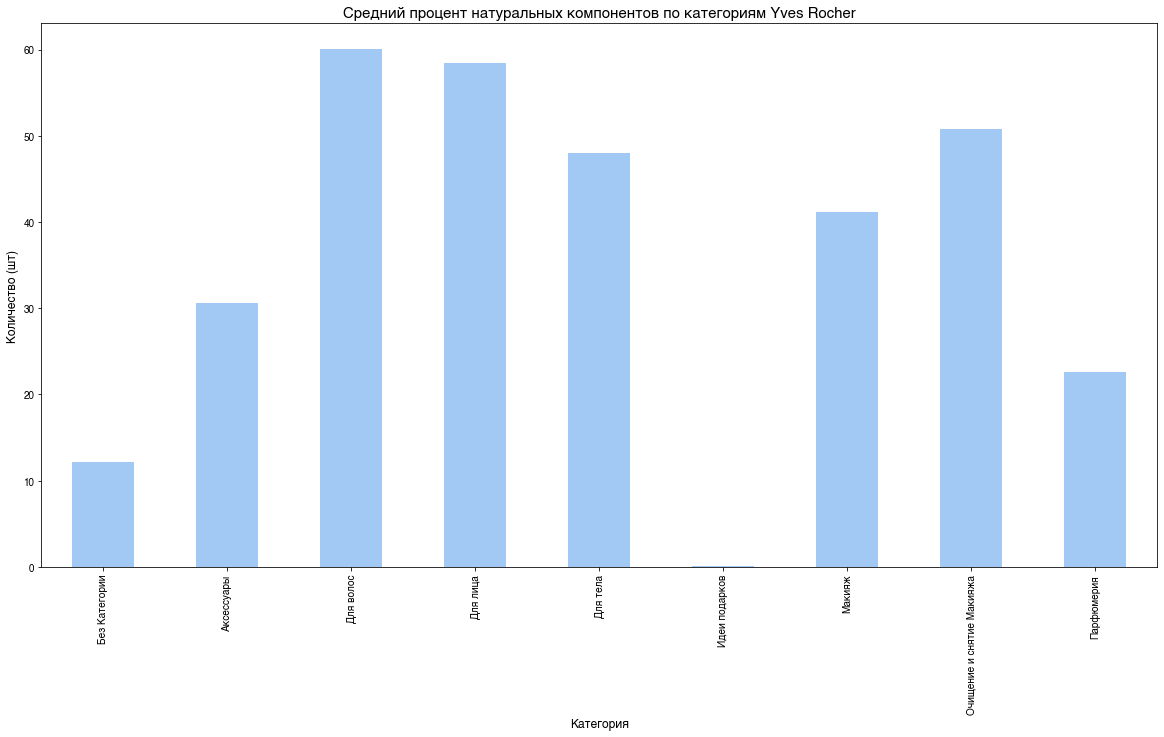

In [911]:
fig = plt.figure(figsize = (20,10))

fig = yves_rocher.groupby('category')['% natural components'].mean().plot(kind='bar')

fig.set_title('Средний процент натуральных компонентов по категориям Yves Rocher',
              fontweight = 'bold',fontsize = 15)
fig.set_xticklabels([ "Без Категории","Аксессуары","Для волос", "Для лица", "Для тела","Идеи подарков","Макияж","Очищение и снятие Макияжа" ,"Парфюмерия"])
fig.set_xlabel('Категория',fontsize = 12)
fig.set_ylabel('Количество (шт)', fontsize = 12)
plt.show()

In [ ]:
'''В товарах Yves Rocher самыми ненатуральными по составами являются товары из категории “Парфюмерия” и “Аксессуары”. 
При этом мы проверили по датафрейму: опасных синтетических ингредиентов среди всех синтетических нет.'''


Для подсчета синтечисеских компонентов по категориям и в целом для бренда используем метод Counter()

In [259]:
# синтечисеские компоненты для Body shop
cnt_b = Counter()
for i in body_shop['synthetics to avoid']:
    if i != None:
        for j in i:
            cnt_b[j] += 1

In [760]:
# синтечисеские компоненты для Yves Roche
cnt_y = Counter()
for i in yves_rocher['synthetic components']:
    if i != None:
        if i != " ":
            for j in i:
                cnt_y[j] += 1

In [198]:
cnt_b

Counter({'Alcohol Denat': 71,
         'Propylene Glycol': 42,
         'Talc': 23,
         'Sodium Chloride': 53,
         'Isopropyl Alcohol': 9,
         'VA Copolymer': 3,
         'Imidazolidinyl Urea': 1})

In [761]:
cnt_y

Counter({'ACADAMIA TERNIFOLIA SEED OIL': 48,
         'TOCOPHEROL': 283,
         'ANGIFERA INDICA SEED OIL': 9,
         'CITRONELLOL': 103,
         'GERANIOL': 128,
         '2936v0': 2,
         'ETHYLPROPANEDIOL': 144,
         'DIMETHICONE': 121,
         'AMMONIUM ACRYLOYLDIMETHYLTAURATE/VP COPOLYMER': 11,
         'NIACINAMIDE': 5,
         'SODIUM BENZOATE': 326,
         'SALICYLIC ACID': 130,
         'ICA': 193,
         'PARFU': 30,
         'ALLANTOIN': 25,
         'ACRYLATES/C10-30 ALKYL ACRYLATE CROSSPOLYMER': 32,
         'POTASSIUM SORBATE': 294,
         '2171v0': 2,
         'PULLULAN': 9,
         'HYDROXYACETOPHENONE': 66,
         'ANNAN': 11,
         'PARFUM/FRAGRANCE': 440,
         '1,2-HEXANEDIOL': 80,
         'CAPRYLYL GLYCOL': 126,
         'ESEMBRYANTHEMUM CRYSTALLINUM EXTRACT': 17,
         'SODIUM CITRATE': 13,
         'AJUGA REPTANS CELL CULTURE EXTRACT': 8,
         '10314v0': 2,
         'HYDROXYETHYL ACRYLATE/SODIUM ACRYLOYLDIMETHYL TAURATE COPOL

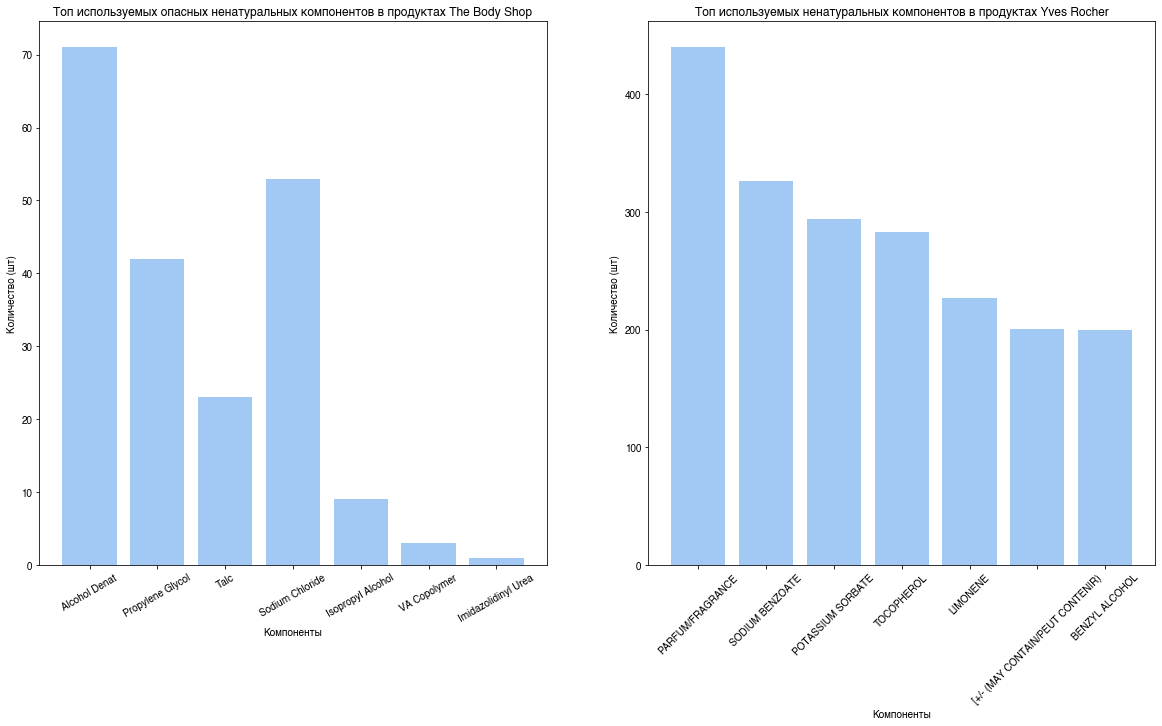

In [869]:
''' Анализ наиболее поплярных ненатуральных компонентов для двух компаний'''

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))

#ax1

ax1.bar(cnt_b.keys(), cnt_b.values())

ax1.set_title('Топ используемых опасных ненатуральных компонентов в продуктах The Body Shop', 
              fontweight = 'bold',
              fontsize = 12)

ax1.set_ylabel('Количество (шт)')
ax1.set_xlabel('Компоненты')
ax1.tick_params(axis='x', rotation=30)

#ax2
y = [count for tag, count in cnt_y.most_common(7)]
x = [tag for tag, count in cnt_y.most_common(7)]

ax2.bar(x,y)

ax2.set_title('Топ используемых ненатуральных компонентов в продуктах Yves Rocher', 
              fontweight = 'bold',
              fontsize = 12)

ax2.set_ylabel('Количество (шт)')
ax2.set_xlabel('Компоненты')
ax2.tick_params(axis='x', rotation=45)


plt.show()

In [ ]:
'''Эти данные также подтверждаются, если мы посмотрим на топ самых используемых ненатуральных ингредиентов. 
Чаще всего в составах встречается PARFUM/FRAGRANCE - ингредиент, название которого уже говорит о том, в какой категории 
товаров он используется.

Чаще всего из опасных синтетических компонентов используются Alcohol Denat, Sodium Chloride и Propylen Glycol. 
По названиям этих ингредиентов трудно предположить, в каких категориях они, как правило, встречаются.'''

In [809]:
def match(x):
    ans = x
    try:
        if re.search('помада',x.lower()) != None:
            ans = 'makeup'
        elif re.search('тени',x.lower()) != None:
            ans = 'makeup'
        elif re.search('палетка',x.lower()) != None:
            ans = 'makeup'
        elif re.search('пудра',x.lower()) != None:
            ans = 'makeup'  
        elif re.search('парфюм',x.lower()) != None:
            ans = 'makeup' 
        elif re.search('для лица',x) != None:
            ans = "face"
        elif re.search('для умывания',x) != None:
            ans = "face"
        elif re.search('дневной крем',x.lower()) != None:
            ans = "face"
        elif re.search('маска',x.lower()) != None:
            ans = "face"
        elif re.search('крем',x.lower()) != None:
            ans = "face"
        elif re.search('для тела',x) != None:
            ans = 'body'
        elif re.search('дезодорант',x.lower()) != None:
            ans = 'body'
        elif re.search('для душа',x) != None:
            ans = 'body'
        elif re.search('для ванны',x) != None:
            ans = 'body'
        elif re.search('для рук', x  ) != None:
            ans = 'hand'
        elif re.search('мыло', x.lower()) != None:
            ans = 'hand'
        elif re.search('для волос', x) != None:
            ans = 'hair'
        elif re.search('для кожи головы', x) != None:
            ans = 'hair'
        elif re.search('кондиционер', x.lower()) != None:
            ans = 'hair'
        elif re.search('шампунь', x.lower()) != None:
            ans = 'hair'
        elif re.search('спрей',x.lower()) != None:
            ans = 'body'
        elif re.search('туалетная вода',x.lower()) != None:
            ans = 'perfume'
        elif re.search('парфюм',x.lower()) != None:
            ans = 'perfume'
        elif re.search('духи',x.lower()) != None:
            ans = 'perfume'
        elif re.search('набор',x.lower()) != None:
            ans = 'accessories'
        elif re.search('суперфуд',x.lower()) != None:
            ans = 'accessories'
        else:
            ans = ' '
    except:
        ans = ' '
        
    return ans
    

In [811]:
a =  body_shop[body_shop.category == '']['product'].apply(lambda x: match(x))

In [812]:
body_shop[body_shop.category == '']['category'] = a

/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [480]:
body_shop2 = body_shop[body_shop['synthetics to avoid'] != ' ']
body_shop2.category = body_shop2[body_shop2.category == '']['product'].apply(lambda x: match(x))

/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [491]:
body_shop2 = body_shop2.reset_index()

In [576]:
body_shop2.to_csv('/Users/polina/se/body_shop2.csv')

In [581]:
body_shop3  = pd.read_excel('/Users/polina/se/body_shop2.xlsx', header = 1)

In [585]:
body_shop2 = body_shop3

In [586]:
# синтечисеские компоненты для Body shop по категориям
cnt2_b = Counter()
for i in range(len(body_shop2)):
     cnt2_b[body_shop2['category'][i]] += 1

In [587]:
cnt2_b

Counter({'face': 58,
         'makeup': 24,
         'body': 43,
         'accessories ': 3,
         'hand': 15,
         'perfume': 10,
         'hair': 11})

In [588]:
cnt2_b.keys(),cnt2_b.values()

(dict_keys(['face', 'makeup', 'body', 'accessories ', 'hand', 'perfume', 'hair']),
 dict_values([58, 24, 43, 3, 15, 10, 11]))

In [849]:
yves_rocher.category.unique()

array(['Для Лица', 'Идеи Подарков', 'Очищение и снятие макияжа',
       'Для Тела', 'Макияж', 'Для Волос', 'Парфюмерия', 'Аксессуары', ' '],
      dtype=object)

In [848]:
yves_rocher.category[yves_rocher.category == 'Monoï - Моной '] = 'Аксессуары'

/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


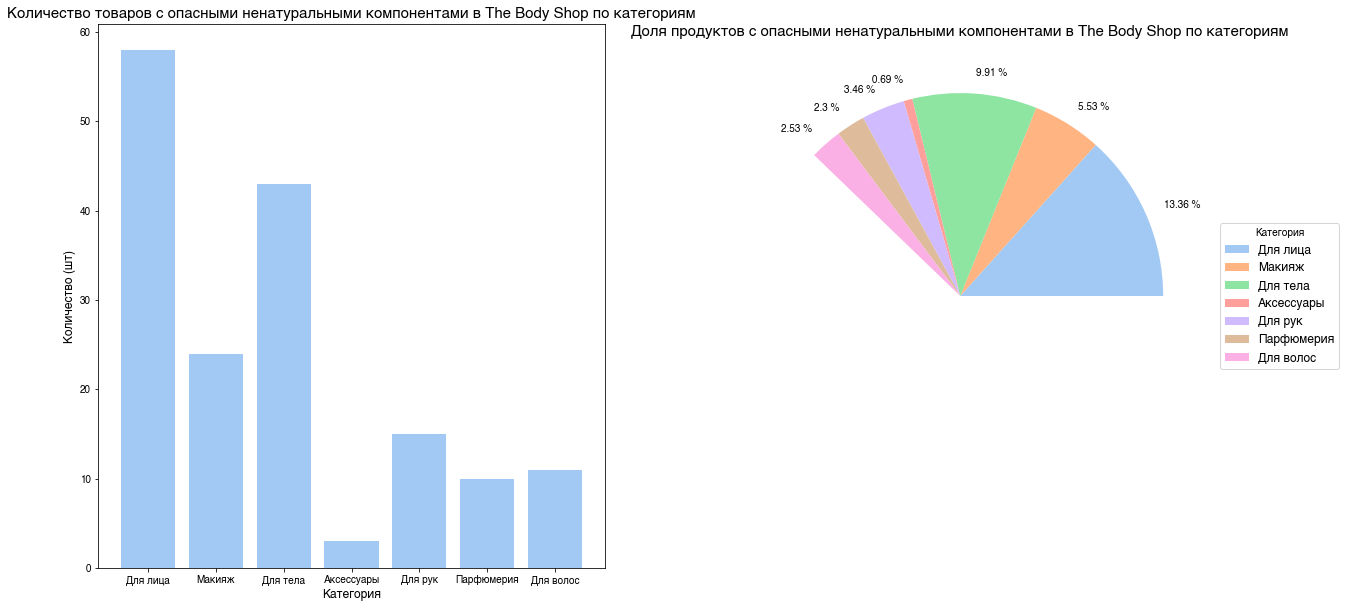

In [879]:
''' Анализ использования не натуральных компонентов для двух компаний по категориям продуктов'''

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))

#ax1

x = np.array([v for v in cnt2_b.values()])
y = np.array([v for v in cnt2_b.keys()])

ax1.bar(y, x)

ax1.set_title('Количество товаров с опасными ненатуральными компонентами в The Body Shop по категориям', 
              fontweight = 'bold',
              fontsize = 15)
ax1.set_xticklabels(["Для лица","Макияж","Для тела","Аксессуары","Для рук","Парфюмерия", "Для волос"])
ax1.set_ylabel('Количество (шт)',fontsize = 12)
ax1.set_xlabel('Категория',fontsize = 12)

ax1.tick_params(axis='x')

#ax2

ax2.pie([float(v/434) for v in cnt2_b.values()], labels = ([str(np.round(float(v/434)*100,2))+ " %" for v in cnt2_b.values()]))

ax2.legend(["Для лица","Макияж","Для тела","Аксессуары","Для рук","Парфюмерия", "Для волос"],
           title= "Категория",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
           fontsize = 12)

ax2.set_title('Доля продуктов с опасными ненатуральными компонентами в The Body Shop по категориям',fontweight = 'bold',
              fontsize = 15)

plt.show()

In [ ]:
'''Наиболее часто опасные синтетические компоненты встречаются в товарах категорий "Для лица", "Для тела" и "Макияж". 
Можно предположить, что самые используемые из вредных ингредиентов, чаще используются именно в этих категориях.'''

In [518]:
body_shop['price'][body_shop['price'] == '-']= 0
body_shop['price'] = body_shop['price'].apply(lambda x: int(x))

In [593]:
body_shop2['price'][body_shop2['price'] == '-']= 0
body_shop2['price'] = body_shop2['price'].apply(lambda x: int(x))

/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [763]:
yves_rocher['price'] = yves_rocher['price'].apply(lambda x: 0 if len(x) == 0 else int(x))

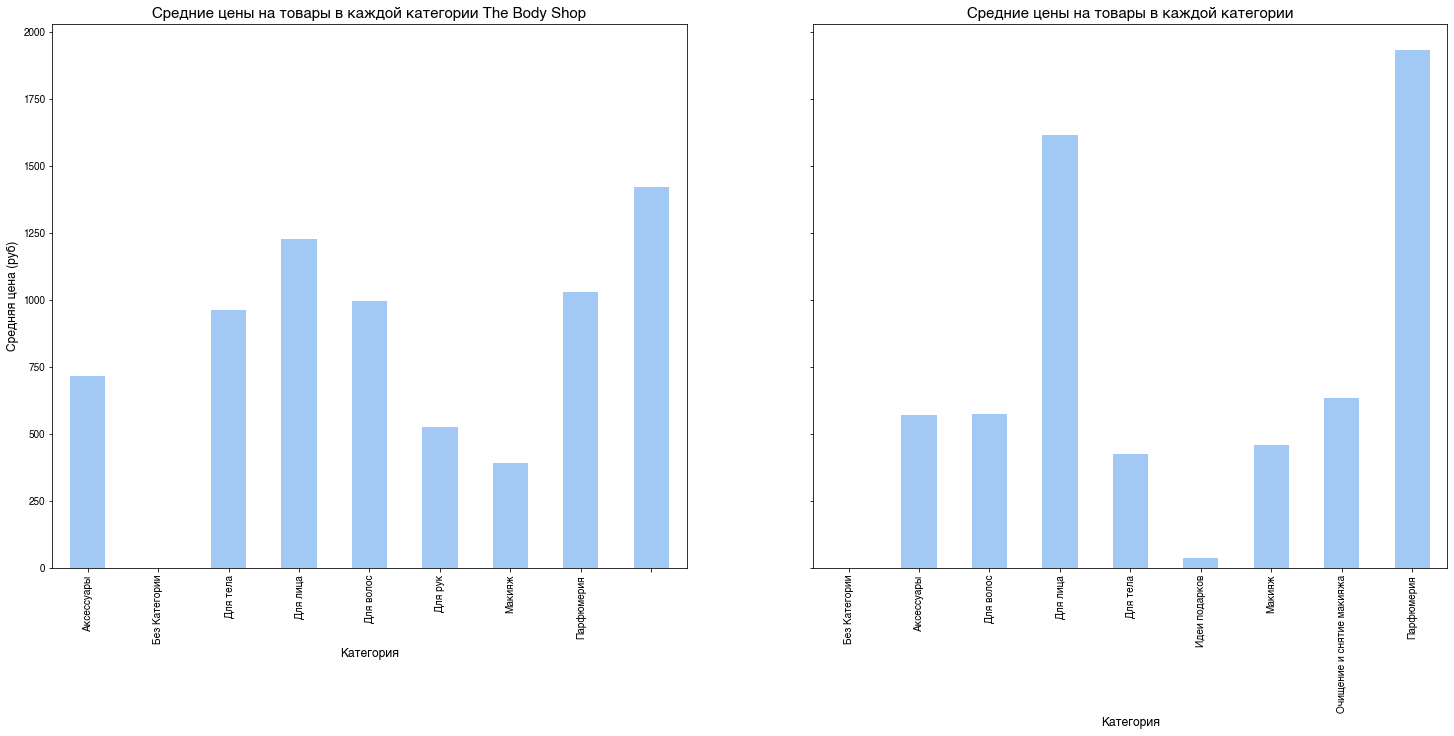

In [975]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (25,10), sharey=True)

#ax1

body_shop.groupby('category')['price'].mean().plot(kind = 'bar', ax = ax1)

ax1.set_title('Cредние цены на товары в каждой категории The Body Shop', 
              fontweight = 'bold',
              fontsize = 15)

ax1.set_xticklabels(["Аксессуары","Без Категории","Для тела", "Для лица", "Для волос","Для рук","Макияж", "Парфюмерия"])

ax1.set_ylabel('Средняя цена (руб)', fontsize = 12)
ax1.set_xlabel('Категория',fontsize = 12)

#ax2

yves_rocher.groupby('category')['price'].mean().plot(kind = 'bar', ax = ax2)

ax2.set_title('Cредние цены на товары в каждой категории', 
              fontweight = 'bold',
              fontsize = 15)
ax2.set_xticklabels([ "Без Категории","Аксессуары","Для волос", "Для лица", "Для тела","Идеи подарков","Макияж","Очищение и снятие макияжа" ,"Парфюмерия"])

ax2.set_ylabel('Средняя Цена (руб)', fontsize = 12)
ax2.set_xlabel('Категория',fontsize = 12)
plt.show()

In [ ]:
'''Данные по соотношению цены и натуральных составов неоднозначны. Категория “Парфюмерия” содержит самые дорогие товары, 
хотя в них выше доля ненатуральных ингредиентов. При этом товары для лица, в которых один из самых высоких показателей 
по натуральности составов, является также второй по уровню средней цены. В дальнейшем мы ещё раз обратимся к этим данным, 
чтобы посмотреть корреляцию цены и оценок с учётом данных по натуральности составов.

Данные по соотношению цены и натуральных составов неоднозначны. Категория “Для лица” содержит самые дорогие товары без учета 
товаров в редких категориях (не подписаны на графике, чтобы не перегрузить), хотя именно в этой категории часто встречались 
опасные синтетические ингредиенты. При этом у товаров для макияжа, в которых один из самых высоких показателей по содержанию 
опасных ингредиентов, самые низкие цены.'''

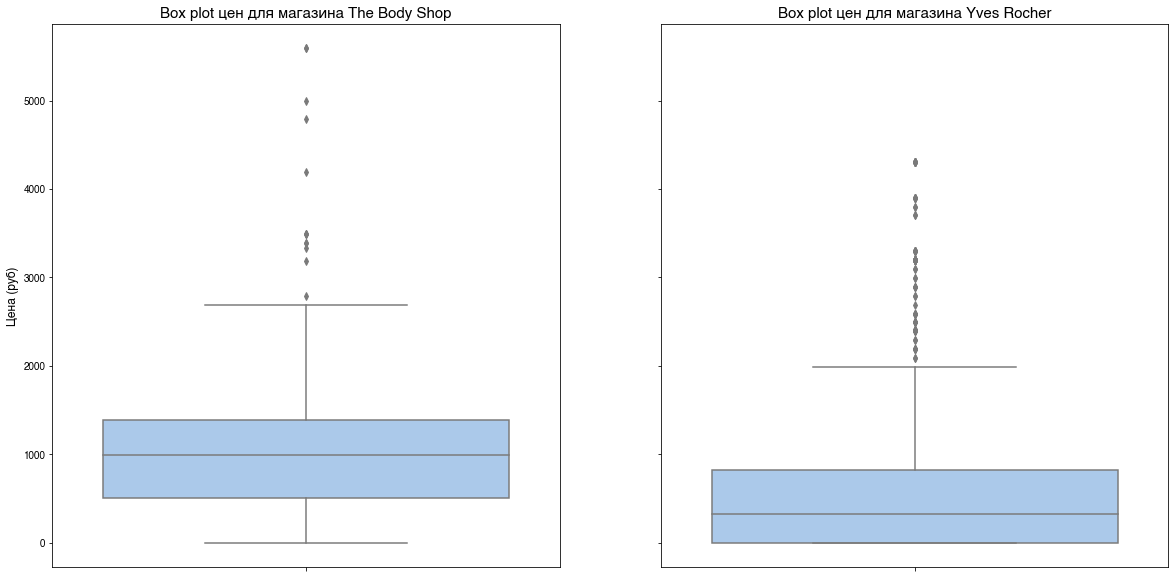

In [854]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10), sharey=True)

sns.boxplot(y = body_shop['price'], ax = ax1)
ax1.set_title('Box plot цен для магазина The Body Shop',fontweight = 'bold',fontsize = 15)

ax1.set_ylabel('Цена (руб)', fontsize = 12)


ax2 = sns.boxplot(y = yves_rocher['price'])
ax2.set_title('Box plot цен для магазина Yves Rocher',fontweight = 'bold',fontsize = 15)

ax2.set_ylabel(' ', fontsize = 12)

plt.show()

In [ ]:
'''Прежде чем анализировать зависимость разных показателей от цены, посмотрим, нет ли аномальных значений по цене. 
Построив ящики с усами, видим, что аномально низких значений нет, а аномально высоких немного относительно общего числа 
товаров. Это значит, что избавляться от выбросов не имеет большого смысла.

По ящику с усами для Yves Rocher видим, что товары обычно дешевле, чем в The Body Shop.'''

In [528]:
body_shop['reviews'][body_shop['reviews'] == '-']= 0
body_shop['reviews'] = body_shop['reviews'].apply(lambda x: int(x))

/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [863]:
yves_rocher2 = yves_rocher[yves_rocher['stars']!= '']
yves_rocher2['reviews'] = yves_rocher2['stars'].apply(lambda x: float(x.replace(',', '.'))*20)

/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [873]:
yves_rocher2['number of reviews'] = yves_rocher2['number of reviews'].apply(lambda x: int(x))

/Users/kseniayakunina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


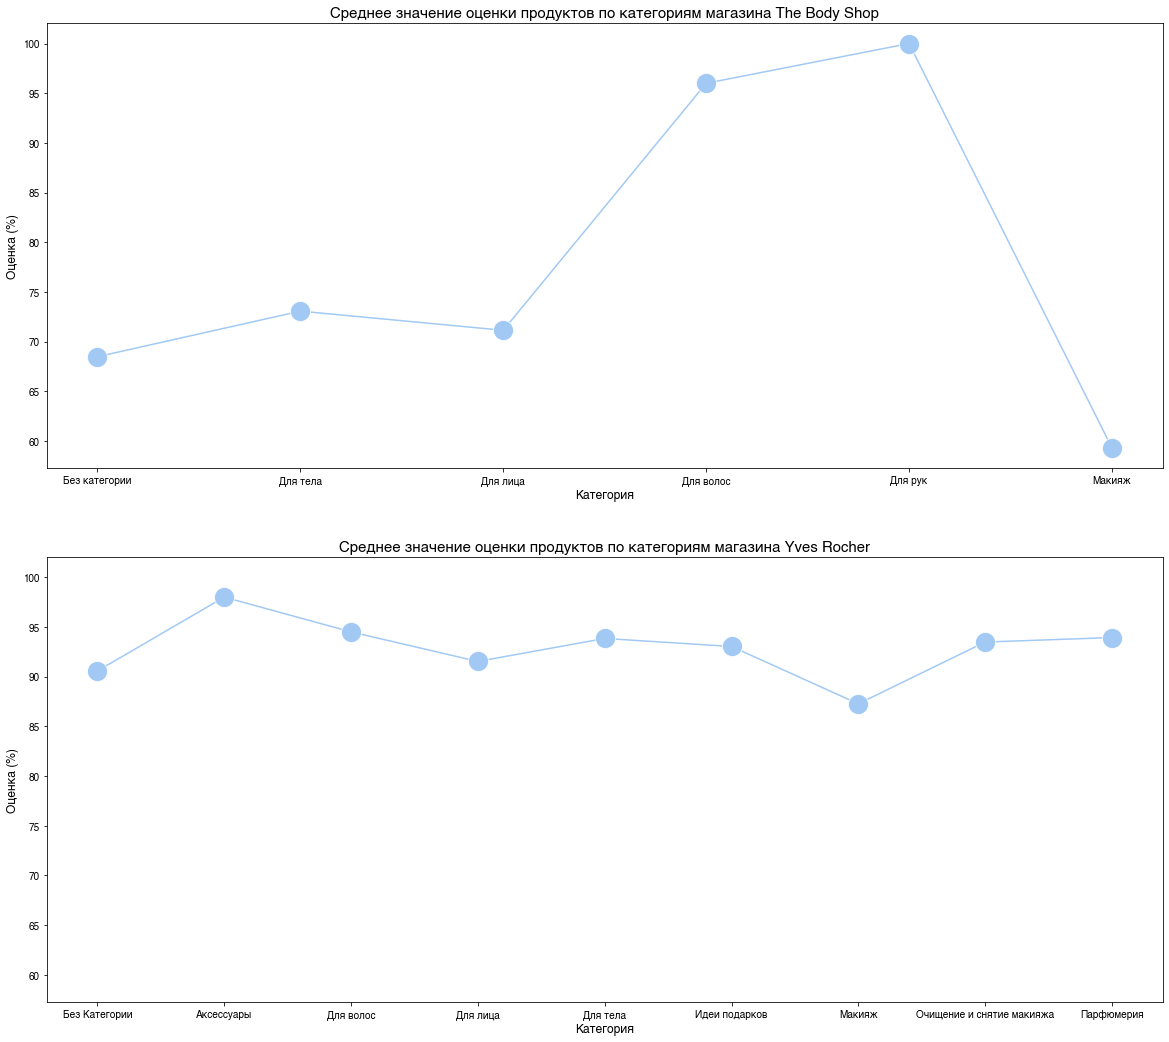

In [910]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (20,18), sharey=True)

data = body_shop.groupby('category')['reviews'].mean()

sns.lineplot(x = list(data.index), y = list(data.values), marker='o', markersize = 20,linestyle='', ax = ax1)
ax1.set_title("Среднее значение оценки продуктов по категориям магазина The Body Shop", fontsize = 15)
ax1.set_xlabel('Категория',fontsize = 12)
ax1.set_ylabel('Оценка (%)', fontsize = 12)
ax1.set_xticklabels(["Без категории","Для тела", "Для лица", "Для волос","Для рук","Макияж"])

data = yves_rocher2.groupby('category')['reviews'].mean()

ax2 = sns.lineplot(x = list(data.index), y = list(data.values), marker='o', markersize = 20,linestyle='')
ax2.set_title("Среднее значение оценки продуктов по категориям магазина Yves Rocher", fontsize = 15)
ax2.set_xticklabels([ "Без Категории","Аксессуары","Для волос", "Для лица", "Для тела","Идеи подарков","Макияж","Очищение и снятие макияжа" ,"Парфюмерия"])
ax2.set_xlabel('Категория',fontsize = 12)
ax2.set_ylabel('Оценка (%)', fontsize = 12)



plt.show()

In [ ]:
'''В The Body Shop заметна интересная корреляция: у трёх категорий товаров, в которых больше всего опасной синтетики, 
самые низкие оценки от пользователей. Правда, эти показатели не прямо пропорциональны. Если расположить категории по убыванию 
количества вредных компонентов, получится: “Для лица”, “Для тела”, “Макияж”. Если их же расположить в порядке “от самой 
высокой средней оценки к самой низкой”, будет: “Для тела”, “Для лица”, “Макияж”.'''

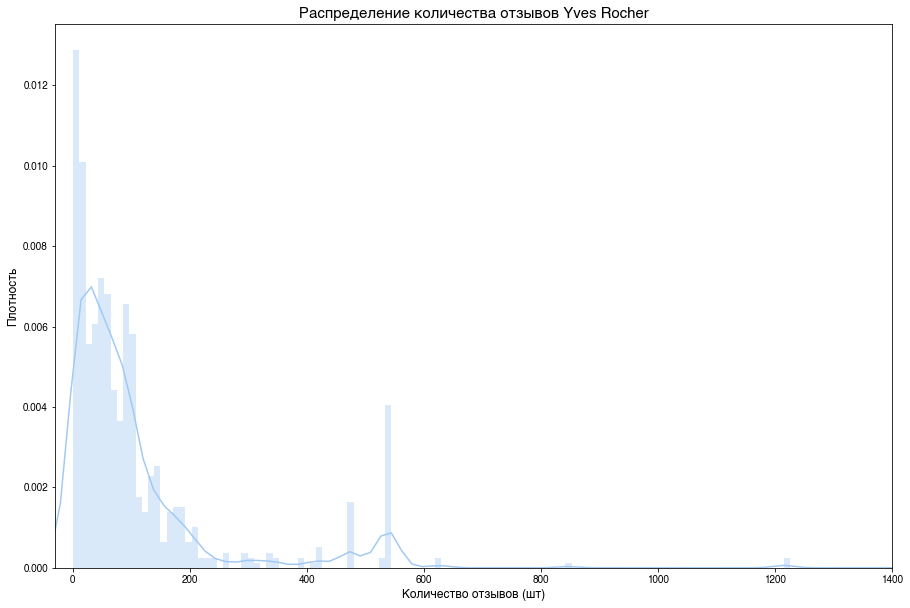

In [908]:
fig, ax= plt.subplots(figsize = (15,10))

fig = sns.distplot(yves_rocher2['number of reviews'], bins = 200)

fig.set_title("Распределение количества отзывов Yves Rocher", fontsize = 15)
fig.set(xlim=(-30,1400))
fig.set_xlabel('Количество отзывов (шт)',fontsize = 12)
fig.set_ylabel('Плотность',fontsize = 12)
plt.show()

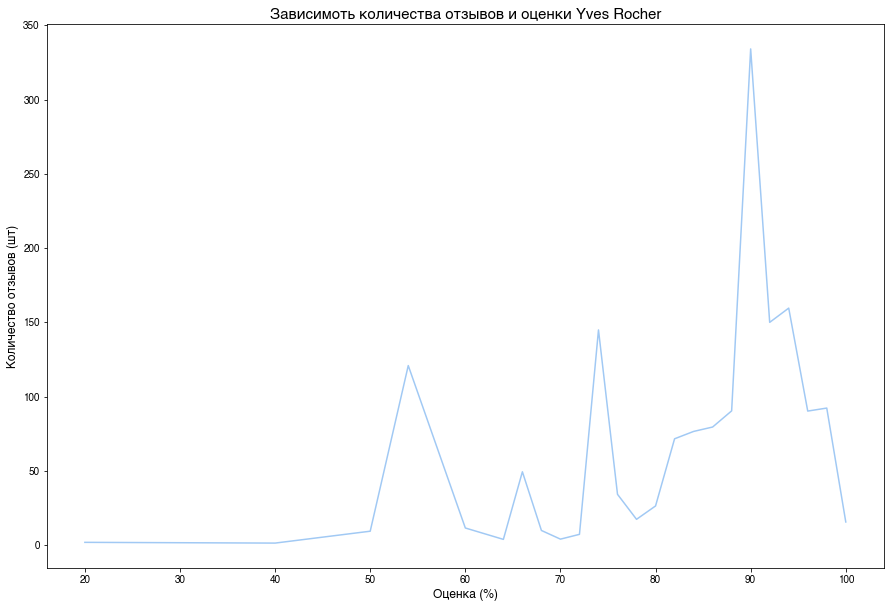

In [875]:
fig = plt.figure(figsize = (15,10))

fig = sns.lineplot(y = yves_rocher2['number of reviews'], x = yves_rocher2['reviews'],ci = None)

fig.set_title("Зависимоть количества отзывов и оценки Yves Rocher", fontsize = 15)
fig.set_xlabel('Оценка (%)',fontsize = 12)
fig.set_ylabel('Количество отзывов (шт)', fontsize = 12)

plt.show()

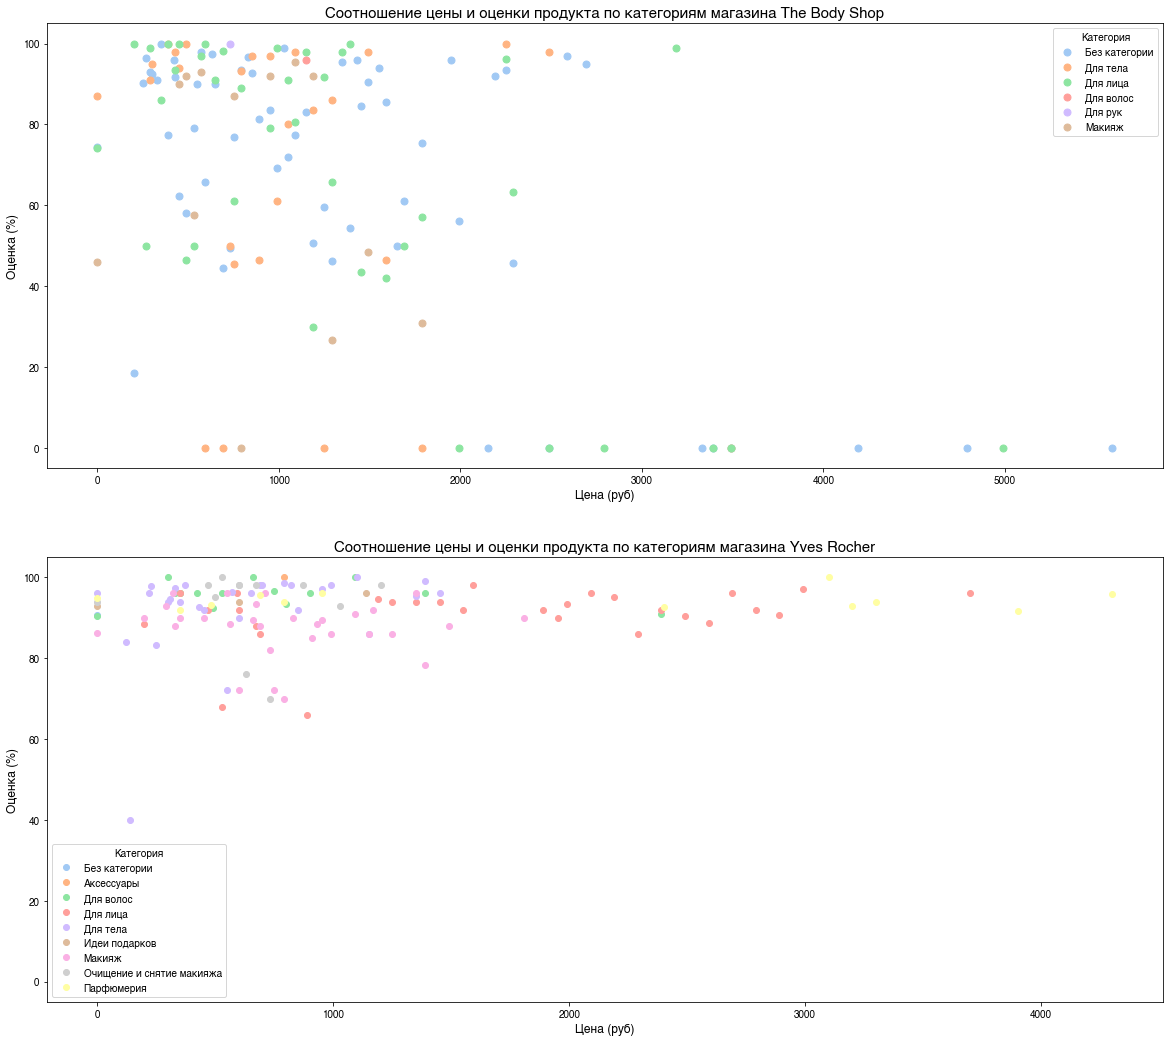

In [909]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (20,18), sharey=True)

body_shop.pivot_table("reviews", "price", "category").plot(marker="o",markersize = 7,linestyle='', ax = ax1)

ax1.set_title("Соотношение цены и оценки продукта по категориям магазина The Body Shop", fontsize = 15)
ax1.set_xlabel('Цена (руб)',fontsize = 12)
ax1.set_ylabel('Оценка (%)', fontsize = 12)
ax1.legend( ["Без категории","Для тела", "Для лица", "Для волос","Для рук","Макияж"],
    title= "Категория")

yves_rocher2.pivot_table("reviews", "price", "category").plot(marker="o",markersize = 6,linestyle='', ax = ax2)

ax2.set_title("Соотношение цены и оценки продукта по категориям магазина Yves Rocher", fontsize = 15)
ax2.set_xlabel('Цена (руб)',fontsize = 12)
ax2.set_ylabel('Оценка (%)', fontsize = 12)
ax2.legend(["Без категории","Аксессуары",'Для волос','Для лица','Для тела','Идеи подарков',"Макияж", 'Очищение и снятие макияжа','Парфюмерия'],
    title= "Категория")

plt.show()

In [ ]:
'''Прежде чем мы проанализируем, как зависят друг от друга цена, отзывы (оценки) и количество отзывов, рассмотрим отдельно 
оценки и их количество.

Чаще всего товар имеет меньше, чем 100 отзывов от пользователей, что видно графику частотности. 
При этом мы видим по линейному графику (без точек), что существует довольно очевидная зависимость между высотой оценки 
и количеством отзывов у конкретного товара. До оценки 90% чем больше отзывов, тем выше средняя оценка товара. 
Это вывод мы запомним, он пригодится для анализа следующего графика.

Данные о соотношении цены и оценки продуктов в магазине The Body Shop нерепрезентативны: вне зависимости от категории 
и цены оценки, которые получают продукты от покупателей, разбросаны от очень низких до очень высоких. Однако самые 
lорогие товары (стоимостью приблизительно от 3,5 тыс. рублей) получили оценки “0”. Это значит, что покупатели оказались 
недовольны товаром, поскольку, если у товара нет оценок, в ячейку датафрейма добавляется символ “-”.

В Yves Rocher цена и оценка продукта слабо коррелируют с натуральностью состава. Например, оценки для товаров из категории 
“Парфюмерия” и “Макияж”, которые были лидерами по ненатуральности, высокие, как и в других категориях. 

То есть оценки и количество отзывов в большей степени зависят не от количества ненатуральных ингредиентов, а от друг друга.'''

# Выводы

1. Компании не всегда открыто представляют состав своих продуктов.
Эта гипотеза подтвердилась для Yves Rocher уже из данных датафрейма. В категории “Идеи для подарков”, “Парфюмерия” и “Макияж” 
составы часто не прописывались. С точки зрения прозрачности составы должны были прописываться для каждого товара, но этого 
не сделано. Данные предоставляются не полностью.
В некоторых товарах The Body Shop составы тоже не указаны, но категории варьируются  (встречается в товарах для тела, для 
лица и макияжа), как и “типы” товаров (часто в названиях фигурируют “Подарки” и “Наборы”). Тем не менее гипотеза подтверждается.

2. Если компания позиционирует, что ориентируется на натуральные составы, вероятно, она маскирует часть синтетических 
ингредиентов или даже опасных синтетических.
На сайте компании Yves Rocher мы видим обещания, что в составе продукта от 81% до 96% натуральных ингредиентов. 
При этом в процентном соотношении мы видим, что процент натуральных ингредиентов может быть значительно ниже 81%.
Так как компания The Body Shop не разграничивает натуральные и синтетические ингредиенты в составе, то вычислить процент 
натуральных мы не можем. При этом компания использует опасные синтетические ингредиенты, хотя позиционирует натуральность и 
высокое качество на главной странице.
Гипотеза подтвердилась.

3. Чем больше натуральных ингредиентов в составе продукта, тем выше цена, тем выше оценка, тем больше отзывов.
Для Yves Rocher натуральность состава не коррелирует с высотой оценки, количеством отзывов и ценой. Например, товары из 
раздела “Парфюмерия” могут быть дорогими, с низкой долей натуральных компонентов, но получать высокие оценки и большое число 
отзывов.
Для The Body Shop мы заметили, что у трех категорий, где чаще всего встречаются опасные ненатуральные компоненты, самые низкие 
оценки от пользователей ( “Для лица”, “Для тела”, “Макияж”). При этом данные не позволяют судить о корреляции между ценой и 
натуральностью товаров, между ценой и количеством оценок.
Гипотеза подтвердилась лишь частично.

4. Приверженность натуральным составам варьируется в разных категориях товаров.
Для Yves Rocher приверженность натуральным составам варьируется в среднем от 25% в парфюмерии до 60% в средствах для волос.
Для The Body Shop опасные синтетические товары тоже встречались с разной частотностью в разных категориях товаров: от 
примерно 3% в аксессуарах до 58% в товарах для лица.
Гипотеза подтверждается.

5. Больше всего синтетических ингредиентов в категории "Парфюмерия".
Для Yves Rocher эта гипотеза подтвердилась.
Для The Body Shop она не подтвердилась, если мы учитываем данные по опасным синтетическим ингредиентам. 
Они чаще всего встречаются не в “Парфюмерии”, а в товарах для лица.

# Обязанности

Формулировка гипотез и цели (Анна Опыхтина)
Формулировка задач (Полина Меньшова)
Сбор данных с экспертного портала по дерматологии (Полина Меньшова)
Сбор данных с сайта Yves Rocher (Анна Опыхтина)
Предобработка данных с сайта Yves Rocher (Анна Опыхтина)
Датафрейм с данными Yves Rocher (Анна Опыхтина)
Сбор данных с сайта The Body Shop (Полина Меньшова)
Предобработка данных с сайта The Body Shop (Полина Меньшова)
Датафрейм с данными The Body Shop (Полина Меньшова)
Сопоставление составов продуктов с сайтов Yves Rocher и The Body Shop со списком опасных синтетических ингредиентов 
(Полина Меньшова)
График “Средний процент натуральных компонентов по категориям Yves Rocher” (Анна Опыхтина)
График “Топ используемых опасных ненатуральных компонентов в продуктах The Body Shop” (Полина Меньшова)
График “Топ используемых ненатуральных компонентов в продуктах Yves Rocher” (Анна Опыхтина)
Графики “Количество товаров с опасными ненатуральными компонентами в The Body Shop по категориям” и 
“Доля продуктов с опасными ненатуральными компонентами в The Body Shop по категориям” (Полина Меньшова)
График “Соотношение средней цены с искусственными составами The Body Shop” (Полина Меньшова)
График “Соотношение средней цены с искусственными составами Yves Rocher” (Анна Опыхтина)
Box plot цен для магазина The Body Shop (Полина Меньшова)
Box plot цен для магазина Yves Rocher (Анна Опыхтина)
График “Среднее значение оценки продуктов по категориям магазина The Body Shop” (Полина Меньшова)
График “Среднее значение оценки продуктов по категориям магазина Yves Rocher” (Анна Опыхтина)
График “Распределение количества отзывов Yves Rocher” (Анна Опыхтина)
График “Зависимость количества отзывов и оценки Yves Rocher” (Анна Опыхтина)
График “Соотношение цены и оценки продукта по категориям магазина The Body Shop” (Полина Меньшова)
График “Соотношение цены и оценки продукта по категориям магазина Yves Rocher” (Анна Опыхтина)
Выводы по данным магазина The Body Shop (Полина Меньшова)
Выводы по данным магазина Yves Rocher и общие выводы (Анна Опыхтина)